## Predicting House Prices using Regression Model with Boston Housing Price Dataset


In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

2023-08-25 20:14:21.454324: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 20:14:21.496616: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 20:14:21.497592: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 20:14:22.653425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


57026/57026 [==============================] - 0s 3us/step


## Data Preprocessing: Feature Scaling

In preparation for training the regression model, we need to perform feature scaling to ensure that the features are on similar scales. This step can enhance the performance of the model and prevent certain features from dominating others due to their larger magnitudes.

We'll use the NumPy library to compute the mean and standard deviation of the training data, and then scale both the training and test data accordingly.



In [2]:
import numpy as np

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

## Building a Regression Model with Keras

This code defines a function `build_model()` to create a regression model using the Keras library. The model architecture consists of three layers:

1. **Dense Layer with ReLU Activation (64 units)**: The first hidden layer contains 64 units and uses the Rectified Linear Unit (ReLU) activation function. ReLU is commonly used to introduce non-linearity in neural networks.

2. **Dense Layer with ReLU Activation (64 units)**: The second hidden layer, also with 64 units and ReLU activation, further captures complex relationships in the data.

3. **Dense Layer (1 unit)**: The output layer has a single unit, which is typical for regression tasks. It produces a continuous numeric output.

The model is compiled with the 'rmsprop' optimizer and the mean squared error (MSE) loss function. The Mean Absolute Error (MAE) is chosen as a metric to monitor during training.

Overall, this architecture is a simple yet effective choice for predicting house prices based on the Boston Housing Price dataset.


In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras

def build_model() :
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-Fold Cross Validation for Model Evaluation

In this code snippet, we implement K-Fold Cross Validation to evaluate the performance of the regression model using the Boston Housing Price dataset. K-Fold Cross Validation is a technique that helps assess model performance on multiple validation sets to ensure robustness.

Here's a breakdown of the steps:

1. Set `k` to 4: We choose to perform 4-fold cross validation, dividing the training data into four subsets.

2. Calculate the number of validation samples: We calculate the number of samples in each validation fold by dividing the length of the training data by `k`.

3. Initialize variables: We set the number of training epochs (`num_epochs`) to 100 and create an empty list `all_scores` to store the Mean Absolute Error (MAE) scores for each fold.

4. Iterate over folds: For each fold `i` from 0 to `k-1`:
   - Create validation data and targets: We extract the validation data and targets for the current fold.
   - Create partial training data and targets: We concatenate the training data and targets from all other folds except the current one to create the partial training data.
   - Build and train the model: We create a new instance of the regression model using the `build_model()` function and train it on the partial training data.
   - Evaluate the model: We evaluate the model's performance on the validation data and compute the Mean Absolute Error (MAE).
   - Store the MAE score: We append the MAE score to the `all_scores` list.

5. Calculate the average MAE: After iterating through all folds, we calculate the average MAE score by taking the mean of all the stored MAE scores using `np.mean(all_scores)`.

The calculated average MAE is approximately 2.31, which indicates that, on average, the model's predictions are off by around $2300. This significant margin suggests that further improvements may be needed to enhance the predictive accuracy of the model.


In [14]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k) :
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
        train_data[(i + 1) * num_val_samples :]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
        train_targets[(i + 1) * num_val_samples :]],
        axis=0
    )

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
        epochs=num_epochs, batch_size=16, verbose=0)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

np.mean(all_scores)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


2.3103790283203125

## Retraining the Model

In this section, we explore the effect of retraining the regression model with a higher number of epochs on its performance. The code snippet demonstrates the process of training the model using K-Fold Cross Validation, but this time with a larger number of epochs.

Here's an overview of the steps taken:

1. Increase the number of epochs: The variable `num_epochs` is set to 500, which is a substantial increase compared to the previous 100 epochs.

2. Initialize a history list: We create an empty list `all_mae_histories` to store the Mean Absolute Error (MAE) history for each fold. This allows us to track how the model's validation performance changes over epochs.

3. Iterate over folds: Similar to the previous code, we iterate over each fold:
   - Create validation data and targets.
   - Create partial training data and targets.
   - Build and train the model on the partial training data, this time specifying the validation data for monitoring during training.
   - Extract the MAE history from the training history and append it to `all_mae_histories`.

By retraining the model with 500 epochs and collecting the MAE history, we can observe how the model's performance evolves over time. This information is valuable for understanding whether the model continues to learn and improve with more training epochs.

Keep in mind that increasing the number of epochs can lead to overfitting if not monitored properly. Further analysis, such as tracking training and validation loss, can help identify the optimal number of epochs for training without overfitting.



In [15]:
num_epochs = 500
all_mae_histories = []

for i in range(k) :
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
        train_data[(i + 1) * num_val_samples :]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
        train_targets[(i + 1) * num_val_samples :]],
        axis=0
    )

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=16, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## Visualizing the Evolution of Validation MAE

To gain insight into how the validation Mean Absolute Error (MAE) changes over epochs, we visualize the average validation MAE history using a line plot.

Here's an overview of the steps taken:

1. Compute the average MAE history: The variable `average_mae_history` is computed by taking the mean of the MAE values at each epoch across all folds. This provides a consolidated view of how the validation MAE changes over the training process.

2. Create the line plot: We use the `matplotlib` library to create a line plot. The x-axis represents the number of epochs, and the y-axis represents the average validation MAE. This plot helps us identify trends and patterns in the model's performance.

3. Customize the plot: We set the x-label as "Epochs" and the y-label as "Validation MAE" to provide context for the axes. The plot is displayed using `plt.show()`.

However, it's worth noting that the first 10 data points on the plot might be on a different scale compared to the rest. To ensure a clearer view of the main trends, we proceed to omit these first 10 data points.

By visualizing the validation MAE history, we can assess whether the model's performance stabilizes or continues to improve over epochs, helping us make informed decisions about training duration and potential adjustments.


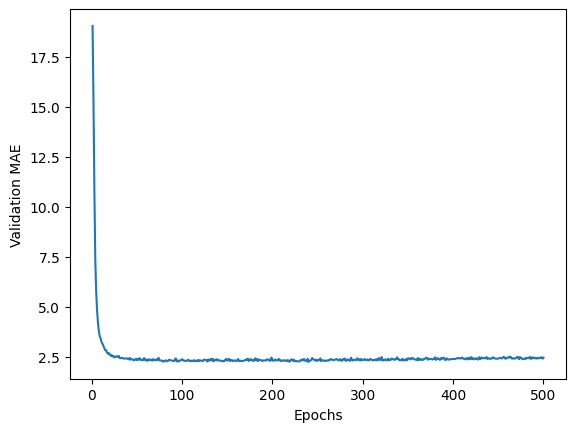

In [16]:
import matplotlib.pyplot as plt

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()




## Observing Model Improvement and Plateau

In this section, we visually explore how the validation Mean Absolute Error (MAE) evolves over training epochs. We use a line plot to illustrate the progression of the model's performance.

Here's what the code and the plot demonstrate:

1. Truncate the MAE history: We initially calculate the average MAE history across all epochs. To enhance the clarity of the plot, we omit the first 10 data points, which might be on a different scale compared to the rest.

2. Create the line plot: Utilizing the `matplotlib` library, we generate a line plot. The x-axis represents the number of epochs, and the y-axis represents the average validation MAE.

3. Interpretation of the plot: Upon observing the truncated MAE history plot, we can discern significant information about the model's behavior during training. Particularly, within the initial epochs, we notice a swift reduction in the validation MAE. This signals that the model is quickly learning and adapting to the training data.

However, the most crucial insight comes when observing the subsequent epochs. At approximately 120-140 epochs, the validation MAE plateaus, indicating that the model's improvement slows down. This signifies that additional training beyond this point might not substantially enhance the model's predictive performance. Going further could even lead to overfitting, where the model becomes too specialized for the training data and performs poorly on new data.

By recognizing the point at which the model's improvement plateaus, we can make informed decisions about the optimal number of training epochs. This balance ensures that the model generalizes well to new data without being overly specialized to the training set.


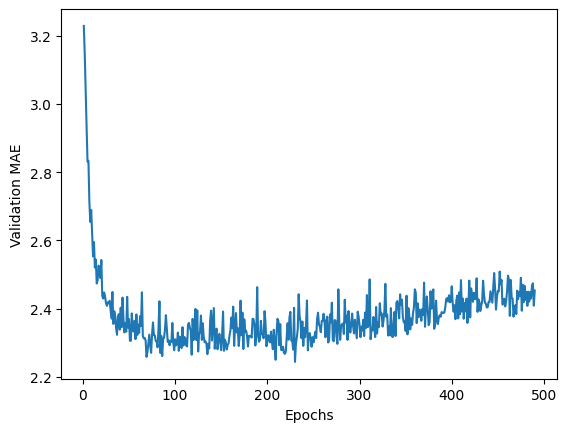

In [17]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


## Final Model Evaluation

After iteratively exploring different training configurations and observing the model's behavior, we arrive at a final training setup to evaluate the regression model's performance.

Here's what the final steps entail:

1. Build the model: We use the `build_model()` function to create the regression model.

2. Training the model: We fit the model on the entire training dataset using the final configuration. In this instance, the model is trained for 130 epochs with a batch size of 16. The training process doesn't produce verbose output (verbose=0), keeping the display concise.

3. Evaluate on test data: After training, we evaluate the model's performance on the test dataset. The evaluation provides us with a Mean Absolute Error (MAE) score that quantifies how closely the model's predictions match the actual test targets.

After evaluating the model on the test data, we find that the MAE score is approximately $2360. This indicates that the model's predictions are, on average, off by around $2360. Despite the efforts to explore various training configurations and analyze the validation MAE trends, we've encountered limitations in improving the predictive accuracy of the model further.

While the model's performance may not have reached the desired level, this evaluation provides valuable insights into the model's capabilities and its generalization to new, unseen data. Further refinement and experimentation may be explored to address the challenges encountered during training.


In [29]:
model = build_model()

model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 3ms/step - loss: 14.2023 - mae: 2.3654


2.365386724472046

## Conclusions and Key Takeaways

In the journey of developing a regression model to predict house prices using the Boston Housing Price dataset, we've explored various aspects of model training, evaluation, and best practices. Here are the key takeaways from our exploration:

1. **Loss Functions in Regression**: Regression tasks involve predicting continuous values, and different loss functions can be used to measure the model's performance. Mean Squared Error (MSE) is a commonly used loss function for regression tasks, which computes the average of the squared differences between predicted and actual values.

2. **Evaluation Metrics for Regression**: In regression tasks, evaluation metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are widely used to quantify the model's predictive accuracy. MAE represents the average absolute difference between predictions and actual values, while RMSE provides a measure of the typical prediction error.

3. **Feature Scaling and Normalization**: When features have varying ranges or units, independent scaling is crucial. Normalizing features ensures that they are on similar scales, preventing certain features from dominating others during model training.

4. **K-Fold Cross Validation**: K-Fold Cross Validation is a robust technique for model evaluation, particularly when there is limited data available. It involves dividing the dataset into 'k' subsets, training the model on 'k-1' subsets, and validating on the remaining subset. This approach helps assess the model's performance across different validation sets.

5. **Model Complexity and Overfitting**: In cases of limited data availability, it's advisable to use a simpler model architecture to prevent overfitting. A small model with few intermediate layers can generalize better when training data is scarce.

Throughout this exploration, we've gained insights into the importance of choosing appropriate loss functions, evaluation metrics, feature scaling, and model complexity when working on regression tasks. While our efforts might not have resulted in the desired predictive accuracy, the process has provided us with valuable insights that can guide future improvements and refinements.

As the field of machine learning continues to evolve, these insights remain foundational for building effective regression models and addressing challenges associated with limited data and predictive accuracy.
